# 1st and Future - Player Contact Detection

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import time
from sklearn.metrics import matthews_corrcoef
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from torch import nn
from tqdm.auto import tqdm

## Load data
> The description of the data can be found at the kaggle competition: https://www.kaggle.com/competitions/nfl-player-contact-detection/data

In [2]:
DATASET_DIR = "dataset"

# player tracking
test_player_tracking_df = pd.read_csv(os.path.join(DATASET_DIR, "test_player_tracking.csv"), 
                                      parse_dates=["datetime"])

# helmet detection
test_helmet_detection_df = pd.read_csv(os.path.join(DATASET_DIR, "test_baseline_helmets.csv"))

# video metadata
test_video_metadata_df = pd.read_csv(os.path.join(DATASET_DIR, "test_video_metadata.csv"), 
                                      parse_dates=["start_time", "end_time", "snap_time"])

# # load the submission dataframe
input_df = pd.read_csv(os.path.join(DATASET_DIR, "sample_submission.csv"))

## Utils

In [3]:
def array_to_image(image_array):
    """returns a PIL image converted from the given image array"""
    if len(image_array) == 0:
        return []
    return Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR))

In [4]:
def step_to_frame(game_play, step, metadata_df, view='Endzone'):
    meta_column = metadata_df[(metadata_df['game_play'] == game_play) &
                             (metadata_df['view'] == view)]
    seconds_to_start = (meta_column['snap_time'] - meta_column['start_time']).iloc[0].total_seconds()
    first_step = -seconds_to_start * 10
    steps_from_start = step - first_step
    seconds_from_start = steps_from_start/10
    frame_number = int(seconds_from_start*60)
    
    return frame_number

In [40]:
step_to_frame("58172_003247", 125, test_video_metadata_df, 'Endzone')

1050

In [6]:
def get_video_frame(game_play, frame_number, view='Endzone', split="train"):
    """
    Returns the given frame from the video given by the game_play value and the indicated view.
    Videos have the name in the following format: "game_play_view"
    
    Parameters:
    game_play (string): game_play id.
    frame (int): the frame we want to extract.
    view (string): the view option we want to extract the frame from. The possible values are:
    ['All29', 'Endzone', 'Sideline'].
    split (string): the dataset split we want to extract the video from. It can be "train" or "test"
    
    Returns:
    PIL Image
    """
    video_name = f"{game_play}_{view}.mp4"
    videopath = os.path.join(DATASET_DIR, split, video_name)
    cap = cv2.VideoCapture(videopath)
    res = False
    while res==False:
        # start at frame_number-1 (starting at 0) and go back 1 frame if it's beyond the length of the video
        frame_number = frame_number-1
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        res, frame = cap.read()
    
    # correct 1 frame offset and return the image and the corrected frame_number as well
    frame_number += 1
    return frame, frame_number

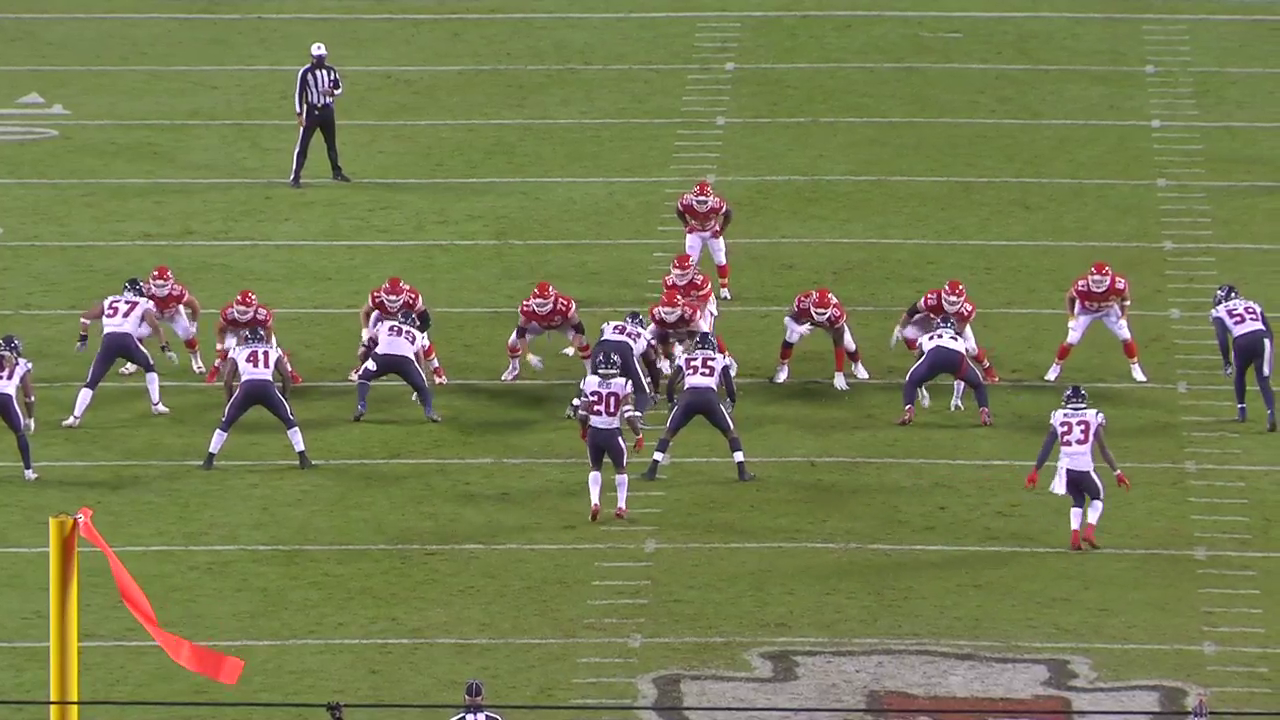

In [7]:
frame_number = step_to_frame("58168_003392", 0, test_video_metadata_df, 'Endzone')
array_to_image(get_video_frame("58168_003392", frame_number, 'Endzone', "test")[0])

In [8]:
def draw_boxes(boxes, labels, image, color=(0, 0, 0)):
    """
    Returns an image array that contains the predicted bounding boxes, labels and scores
    """
    # read the image with OpenCV
    image = np.asarray(image)
    for i, box in enumerate(boxes):
        cv2.rectangle(image,
                     (int(box[0]), int(box[1])), # top-left corner
                     (int(box[2]), int(box[3])), # bottom-right corner
                     color, 2)
        # showing probability scores
        bbox_text = f"{labels[i]}" 
        cv2.putText(image, bbox_text, (int(box[0]), int(box[1]) - 5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, thickness=1,
                   lineType=cv2.LINE_AA)
    
    return image

In [9]:
def get_helmet_detections(helmet_detection_df, game_play, frame_number, view):
    
    detections = helmet_detection_df[(helmet_detection_df['frame'] == frame_number) & 
                            (helmet_detection_df['view'] == view) &
                            (helmet_detection_df['game_play'] == game_play)
                            ][['left', 'width', 'top', 'height', 'player_label']].values
    
    boxes, labels = detections[:, :-1], detections[:, -1]
    # convert boxes to standard format of:
    # [xmin, ymin, xmax, ymax]
    boxes_st = boxes.copy()
    boxes_st[:, 1] = boxes[:, 2] # ymin
    boxes_st[:, 2] = boxes[:, 0] + boxes[:, 1] # xmax
    boxes_st[:, 3] = boxes[:, 2] + boxes[:, 3] # ymax
    boxes = np.array(boxes).astype(int)
    labels = np.array(labels)
    
    return np.array(boxes_st), np.array(labels)

In [10]:
def draw_helmet_detection(helmet_detection_df, game_play, frame_number, view='Endzone', split="train"):
    """
    Returns the given frame from the video given by the game_play value and the indicated view
    with the drawn detection boxes and labels.
    Videos have the name in the following format: "game_play_view"
    
    Parameters:
    helmet_detection_df: the helmet detection dataframe
    game_play (string): game_play id.
    frame (int): the frame we want to extract.
    view (string): the view option we want to extract the frame from. The possible values are:
    ['All29', 'Endzone', 'Sideline'].
    split (string): the dataset split we want to extract the video from. It can be "train" or "test"
    
    Returns:
    PIL Image
    """
    frame, correct_frame_number = get_video_frame(game_play, frame_number, view, split)
    boxes, labels = get_helmet_detections(helmet_detection_df, game_play, correct_frame_number, view)
    
    # draw the detection boxes
    frame = draw_boxes(boxes, labels, frame, color=(0,0,0))
    
    return frame

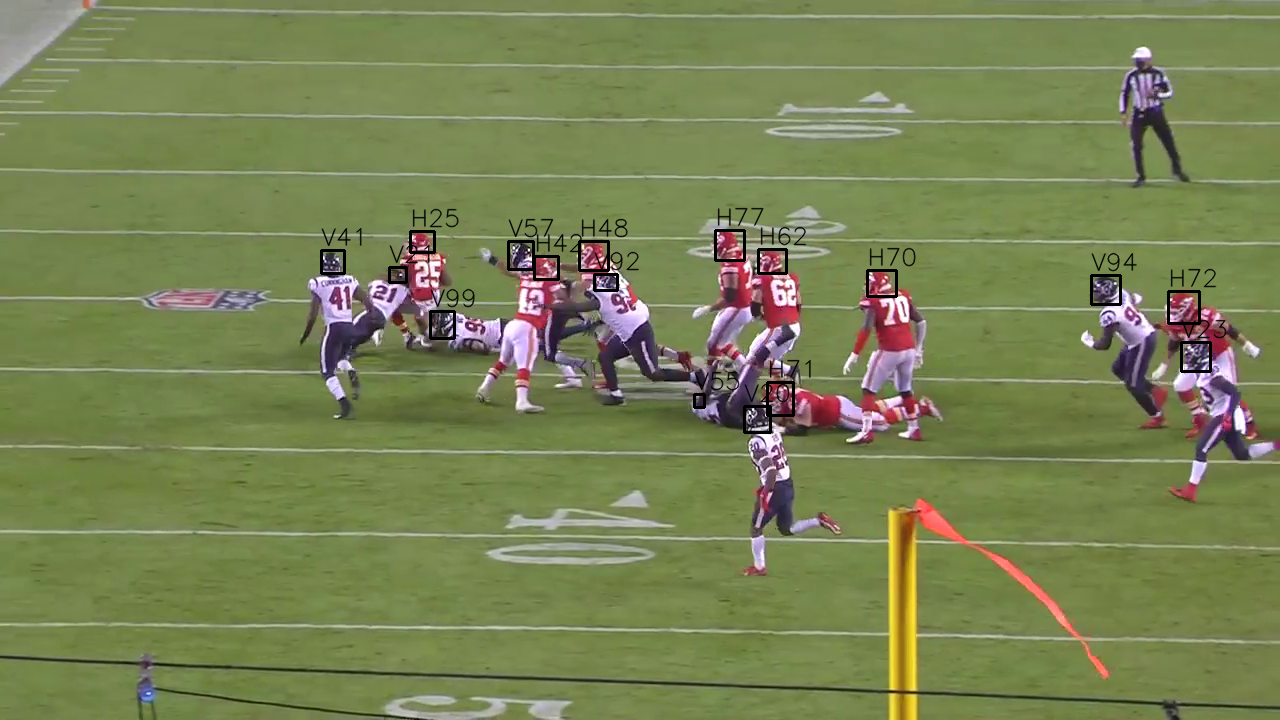

In [11]:
frame_number = step_to_frame("58168_003392", 30, test_video_metadata_df, 'Endzone')
array_to_image(draw_helmet_detection(test_helmet_detection_df, 
                                     "58168_003392", 
                                     frame_number, 
                                     'Endzone', 
                                     "test"))

## YOLO person detection

In [12]:
def get_yolo_detections(yolo_model, image, confidence=0.5):
    """
    Carries out object detection on the given image using the given yolo model.
    Only the detections with a higher confidence interval than the given value are returned.
    Returns a list of bounding box coordinates in the format: ['xmin', 'ymin', 'xmax', 'ymax']
    And a list of the class names of each bounding box.
    """
    results = yolo_model(image)
    results_df = results.pandas().xyxy[0]
    results_df = results_df[results_df['confidence'] > confidence]
    detections = results_df[['xmin', 'ymin', 'xmax', 'ymax', 'name']].values
    boxes, labels = detections[:, :-1], detections[:, -1]
    boxes = np.array(boxes).astype(int)
    labels = np.array(labels)
    
    return boxes, labels

In [13]:
## load yolo model
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in C:\Users\AT016638/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-12-15 Python-3.9.7 torch-1.10.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


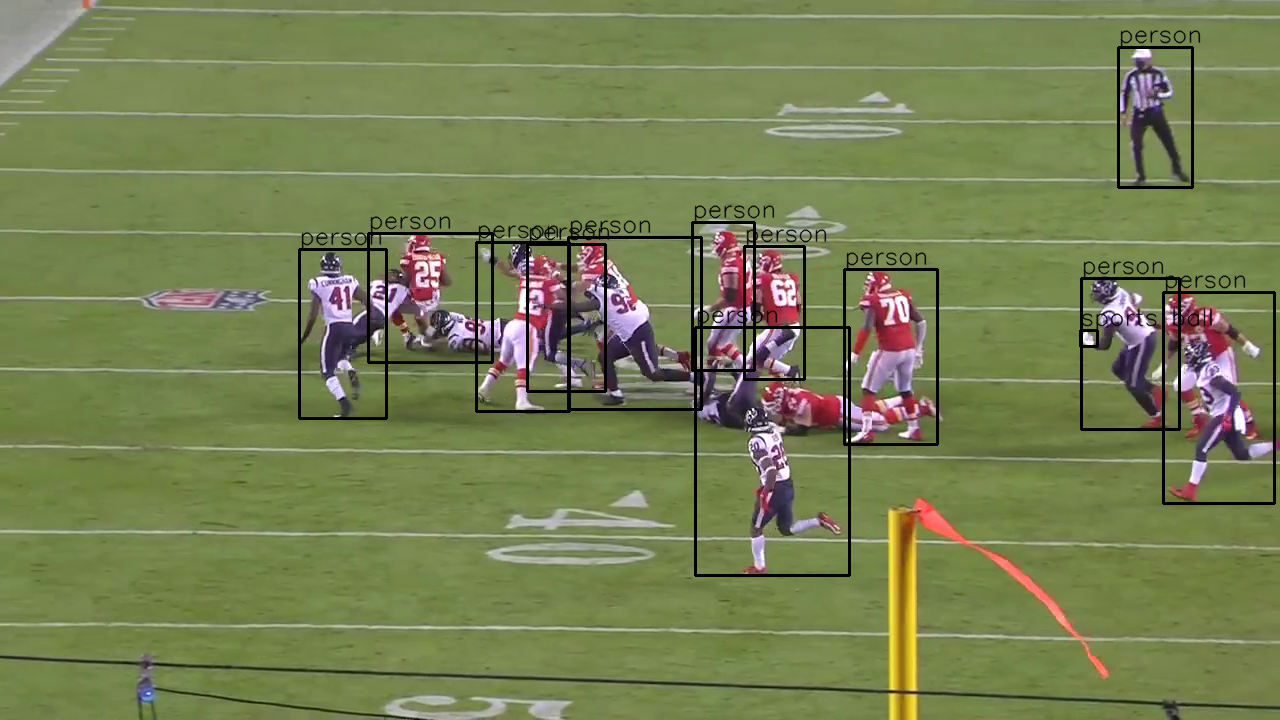

In [14]:
frame_number = step_to_frame("58168_003392", 30, test_video_metadata_df, 'Endzone')
image_array, frame_number = get_video_frame("58168_003392", frame_number, 'Endzone', "test")
image = array_to_image(image_array)
boxes, labels = get_yolo_detections(yolo_model, image, 0.3)
array_to_image(draw_boxes(boxes, labels, image_array))

## Crop image of 2 players

In [15]:
def get_player_label(game_play, player_id, tracking_df):
    """
    Returns the player label from the given player_id in the format of the helmet detection dataframe
    """
    # if the player is the ground, return 'G'
    if (player_id == -1 or player_id == 'G'):
        return 'G'
    
    col = tracking_df.loc[(tracking_df['game_play'] == game_play) & 
                         (tracking_df['nfl_player_id'] == player_id)].iloc[0]
    # get the player jersey number
    player_label = str(col['jersey_number'])
    # put V (away) or H (home) before the jersey number 
    if (col['team'] == 'away'):
        player_label = 'V'+player_label
    else:
        player_label = 'H'+player_label
        
    return player_label

In [16]:
get_player_label("58172_003247", 41937, test_player_tracking_df)

'H57'

In [17]:
def IOU(box_1, box_2):
    """
    Computes the Intersection Over Union (IOU) between two bounding boxes formatted as [x_min, y_min, x_max, y_max]
    """
    # get the right-most left edge between the two bounding boxes
    max_left = max(box_1[0], box_2[0])
    # get the left-most right edge between the two bounding boxes
    min_right = min(box_1[2], box_2[2])
    # compute the intersection width
    intersection_width = min_right - max_left
    
    # get the lowest top edge (y is bigger as it goes lower)
    max_top = max(box_1[1], box_2[1])
    # get the highest bottom edge
    min_bottom = min(box_1[3], box_2[3])
    # compute the intersection height
    intersection_height = min_bottom - max_top
    
    # if the boxes don't intersect, intersection_width or height will be negative
    intersection_area = max(0, intersection_width) * max(0, intersection_height)
    box_1_area = (box_1[2] - box_1[0]) * (box_1[3] - box_1[1])
    box_2_area = (box_2[2] - box_2[0]) * (box_2[3] - box_2[1])
    # get the union area by adding the boxes areas and substracting their intersection
    union_area = box_1_area + box_2_area - intersection_area
    # get the final iou
    iou = intersection_area / union_area
    
    return iou

In [18]:
def filter_helmet_detection(game_play, boxes_helmet, labels_helmet,
                            player_ids, tracking_df):
    """
    From a list of helmet detections, return only the ones that pertain to the player ids
    """
    # get the player labels
    player_labels = [get_player_label(game_play, player_id, tracking_df) for player_id in player_ids]

    # filter the helmet boxes that have the labels from player 1 and 2
    boxes_helmet = boxes_helmet[np.in1d(labels_helmet, player_labels)]
    labels_helmet = labels_helmet[np.in1d(labels_helmet, player_labels)]
    
    return boxes_helmet, labels_helmet

In [19]:
def merge_boxes(box_1, box_2):
    """
    merges two boxes into a single one
    """
    merged_box = [min(box_1[0], box_2[0]), # xmin
                 min(box_1[1], box_2[1]),  # ymin
                 max(box_1[2], box_2[2]),  # xmax
                 max(box_1[3], box_2[3])]  # ymax
    
    return merged_box

In [20]:
def join_boxes_IOU(boxes_1, boxes_2, image_size, view):
    """
    Matches each box from the first set with the box from the second set with highest IOU
    and creates a joined box that contains the two boxes.
    box format: [x_min, y_min, x_max, y_max]
    """
    # average box sizes for each view found on the trainign set
    if(view == 'Endzone'):
        # endzone box averages
        AVG_BOX_WITH = 71 
        AVG_BOX_HEIGHT = 130
    else:
        # sideline box averages
        AVG_BOX_WITH = 40 
        AVG_BOX_HEIGHT = 81
    
    img_width, img_height = image_size
    merged_boxes = []
    num_correct_merges = 0
    for box_1 in boxes_1:
        max_iou = 0
        matched_box = []
        # for each box 1, find the box2 with highes iou
        for box_2 in boxes_2:
            iou = IOU(box_1, box_2)
            if iou > max_iou:
                max_iou = iou
                matched_box = box_2
        # if a matching box has been found, merge the two boxes.
        # if not, save the original box_1 + the average box width and height of the view
        if len(matched_box) !=0:
            merged_box = merge_boxes(box_1, matched_box)
            num_correct_merges += 1
        else:
            # add half the average box width to each side of the horizontal center of the helmet box
            x_center = round((box_1[2] + box_1[0]) / 2)
            x_min = max(0, x_center - round(AVG_BOX_WITH / 2))
            x_max = min(img_width, x_center + round(AVG_BOX_WITH / 2))
            # add the average height to y_max, y_min stays the same as it should be the top of the player head
            y_min = box_1[1]
            y_max = min(img_height, box_1[3] + AVG_BOX_HEIGHT)
            merged_box = [x_min, y_min, x_max, y_max]
        merged_boxes.append(merged_box)
    
    return merged_boxes, num_correct_merges

In [21]:
def get_contact_box(boxes_helmet, labels_helmet,
                    boxes_yolo, labels_yolo, image_size, view):
    """
    Returns the merged contact box between two players and the number of players correctly detected
    """
    # filter the yolo boxes that have "person" as a predicted label
    boxes_yolo = boxes_yolo[labels_yolo == 'person']
    
    # join helmet and person detections
    boxes_player, num_correct_merges =  join_boxes_IOU(boxes_helmet, boxes_yolo, 
                                                       image_size, view)
    
    # if 2 players have been detected, merge their boxes into one
    contact_box = []
    if len(boxes_player) == 2:
        contact_box = merge_boxes(boxes_player[0] , boxes_player[1])
    elif len(boxes_player) == 1:
        contact_box = boxes_player[0]
    
    return contact_box, num_correct_merges

In [22]:
def get_contact_image(game_play, player_id_1, 
                       player_id_2, step, yolo_model, 
                       metadata_df, helmet_detection_df, tracking_df,
                       view='Endzone', split="train", crop=True, max_rewind=120):
    
    frame_number = step_to_frame(game_play, step, metadata_df, view)
    image_array, frame_number = get_video_frame(game_play, frame_number, view, split)
    image = array_to_image(image_array)
    # get the helmet detection boxes and labels
    boxes_helmet, labels_helmet = get_helmet_detections(helmet_detection_df, game_play, frame_number, view)
    # get the yolo detection boxes and labels
    boxes_yolo, labels_yolo = get_yolo_detections(yolo_model, image, 0.3)
    # filter detections of the 2 players
    boxes_helmet, labels_helmet = filter_helmet_detection(game_play, boxes_helmet, 
                                                          labels_helmet, [player_id_1, player_id_2], 
                                                          tracking_df)
    
    # If no helmets where detected, rewind 10 frames at a time for a maximum of max_rewind frames
    # and look for helmet detections again
    rewinded_frames = 0
    while(len(labels_helmet) == 0 and rewinded_frames < max_rewind):
        rewinded_frames += 10
        # detect the helmets on the rewinded frame
        boxes_helmet, labels_helmet = get_helmet_detections(helmet_detection_df, game_play, 
                                                    frame_number-rewinded_frames, view)
        # filter detections of the 2 players
        boxes_helmet, labels_helmet = filter_helmet_detection(game_play, 
                                                            boxes_helmet, 
                                                            labels_helmet, 
                                                            [player_id_1, player_id_2], 
                                                            tracking_df)
    
    # get the contact box
    contact_box, num_dets = get_contact_box(boxes_helmet, labels_helmet,
                                        boxes_yolo, labels_yolo, image.size, view)
    
    # if no helmets have been detected, return empty image
    # TODO use tracking, check previous and next frames
    if len(contact_box) == 0:
        return []
    
    if crop:
        # crop the image
        image_array = image_array[contact_box[1]:contact_box[3], # y coordinates
                                  contact_box[0]:contact_box[2]] # x coordinates
    else:
        # if crop = False, draw the contact and helmets bounding boxes
        image_array = draw_boxes([contact_box], [''], image_array)
        image_array = draw_boxes(boxes_helmet, labels_helmet, image_array)
    
    
    return image_array

In [23]:
test_player_tracking_df

game_play  game_key  play_id  nfl_player_id  \
0      58172_003247     58172     3247          41937   
1      58172_003247     58172     3247          45345   
2      58172_003247     58172     3247          46205   
3      58172_003247     58172     3247          43406   
4      58172_003247     58172     3247          48233   
...             ...       ...      ...            ...   
14867  58168_003392     58168     3392          43395   
14868  58168_003392     58168     3392          39947   
14869  58168_003392     58168     3392          44822   
14870  58168_003392     58168     3392          38590   
14871  58168_003392     58168     3392          46445   

                              datetime  ...  distance direction orientation  \
0     2020-09-13 19:30:20.200000+00:00  ...      0.46     20.74       12.43   
1     2020-09-13 19:30:20.200000+00:00  ...      0.32    179.52      184.91   
2     2020-09-13 19:30:20.200000+00:00  ...      0.20      6.73      339.85   
3     2020-09-13 19:30:20.200000+00:00  ...      0.18    330.50      344.03   
4     2020-09-13 19:30:20.200000+00:00  ...      0.34    166.59      180.56   
...                                ...  ...       ...       ...         ...   
14867 2020-09-11 03:01:57.300000+00:00  ...      0.17     21.01       18.32   
14868 2020-09-11 03:01:57.300000+00:00  ...      0.13    331.22      332.97   
14869 2020-09-11 03:01:57.300000+00:00  ...      0.15    165.22      162.66   
14870 2020-09-11 03:01:57.300000+00:00  ...      0.16    341.08      336.00   
14871 2020-09-11 03:01:57.300000+00:00  ...      0.11     15.34       57.10   

       acceleration    sa  
0              3.13  3.00  
1              1.87 -1.81  
2              0.69 -0.68  
3              0.62  0.39  
4              0.88 -0.87  
...             ...   ...  
14867          0.35 -0.20  
14868          0.58 -0.56  
14869          0.38 -0.07  
14870          0.41 -0.41  
14871          0.25 -0.25  

[14872 rows x 17 columns]

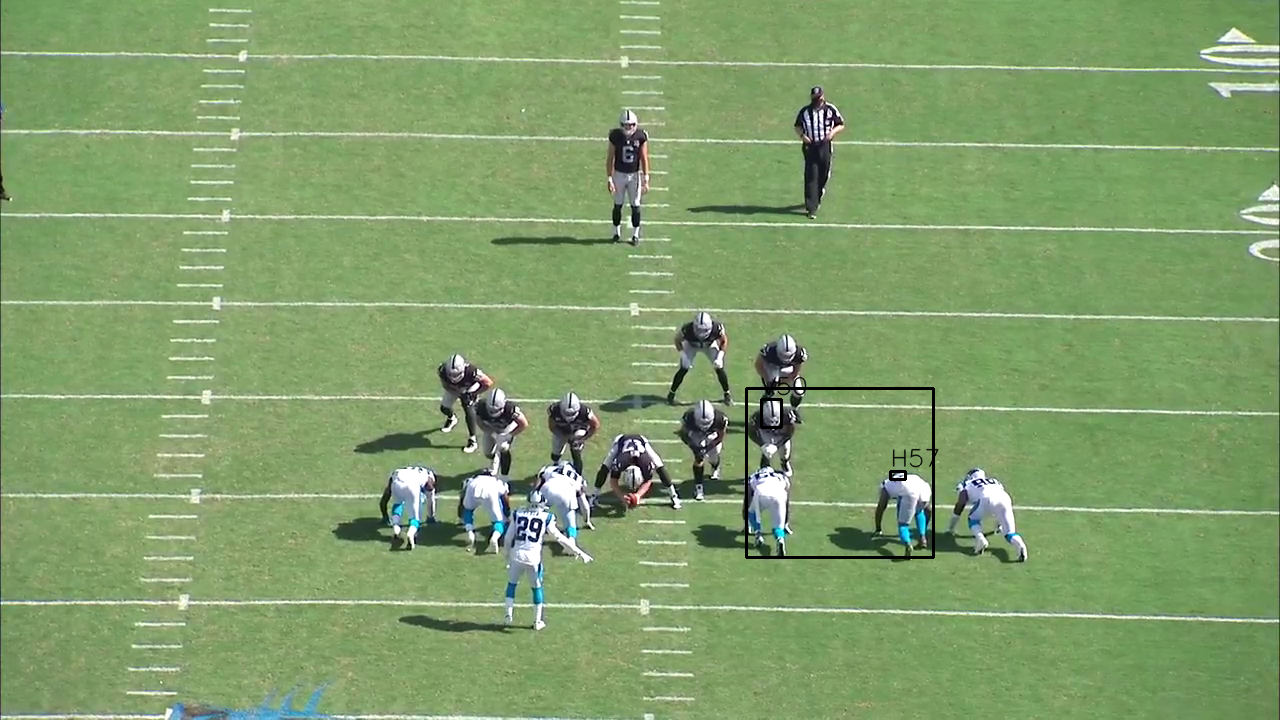

In [24]:
array_to_image(get_contact_image('58172_003247', 41937, 45345, 0, yolo_model, 
                   test_video_metadata_df, test_helmet_detection_df, 
                   test_player_tracking_df, 'Endzone', 'test', crop=False))

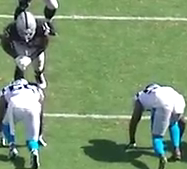

In [25]:
array_to_image(get_contact_image('58172_003247', 41937, 45345, 0, yolo_model, 
                   test_video_metadata_df, test_helmet_detection_df, 
                   test_player_tracking_df, 'Endzone', 'test', crop=True))

## Data Preprocessing
Extract the player to player distance and add tracking information to the input contact dataframe

### Extract the contact info

In [26]:
def extract_contact_id_info(input_df):
    # game_key, play_id, player_1_id, player_2_id, step
    contact_df = pd.DataFrame()
    split = input_df['contact_id'].str.split("_")
    contact_df['contact_id'] = input_df['contact_id']
    contact_df['game_play'] = split.str[0]+'_'+split.str[1]
    contact_df['step'] = split.str[2].astype("int")
    contact_df['nfl_player_id_1'] = split.str[3]
    contact_df['nfl_player_id_2'] = split.str[4]
    # replace ground 'G' players id with '-1'
    contact_df.loc[contact_df["nfl_player_id_2"] == 'G', 'nfl_player_id_2'] = '-1'
    contact_df['nfl_player_id_1'] = contact_df['nfl_player_id_1'].astype('int')
    contact_df['nfl_player_id_2'] = contact_df['nfl_player_id_2'].astype('int')
    
    return contact_df

In [27]:
def add_contact_tracking_info(contact_df, tracking_df):
    """
    Joins a contact dataframe with player tracking dataframe on both players
    """
    player_specific_columns=["team", "position", "jersey_number",
                              "x_position", "y_position", "speed", 
                              "distance", "direction", "orientation",
                              "acceleration", "sa"]
    # join on player 1
    contact_df = contact_df.merge(tracking_df, 
                                 left_on=['game_play', 'nfl_player_id_1', 'step'], 
                                 right_on=['game_play', 'nfl_player_id', 'step'], 
                                 how='left').drop_duplicates()
    # remove the repeated column
    contact_df.drop(["nfl_player_id"], axis=1, inplace=True)
    # rename player 1 specific tracking data
    contact_df.rename(columns=lambda x: x+'_1' if x in player_specific_columns else x, inplace=True)

    # join on player 2
    # avoid repeating the "game_key", "play_id", 'datetime' columns
    contact_df = contact_df.merge(tracking_df.drop(['game_key', 'play_id', 'datetime'], axis=1), 
                                 left_on=['game_play', 'nfl_player_id_2', 'step'], 
                                 right_on=['game_play', 'nfl_player_id', 'step'], 
                                 how='left').drop_duplicates()
    # remove the repeated column
    contact_df.drop("nfl_player_id", axis=1, inplace=True)
    # rename player 2 specific tracking data
    contact_df.rename(columns=lambda x: x+'_2' if x in player_specific_columns else x, inplace=True)
    contact_df.replace(np.nan, 0, inplace=True)
    
    return contact_df

### Computing the distance between players

In [28]:
def compute_distance(contact_df):
    # compute the distance between 2 players
    contact_df["p2p_distance"] = np.sqrt(
        np.square(contact_df["x_position_1"] - contact_df["x_position_2"])
        + np.square(contact_df["y_position_1"] - contact_df["y_position_2"])
    )
    # set the distance between a player and the ground to 999
    contact_df.loc[contact_df["nfl_player_id_2"]==-1, 'p2p_distance'] = 999
    contact_df['p2p_distance'] = contact_df['p2p_distance'].fillna(999)
    return contact_df

### Final preprocessing function

In [29]:
def preprocess_input(input_df, tracking_df):
    """Returns the preprocessed dataframe with all the expanded contact_id info, tracking data, distance
    and ground truth"""
    # tracking df contains all data from the test tracking df
    contact_df = extract_contact_id_info(input_df)
    # add tracking info to the contact df
    contact_df = add_contact_tracking_info(contact_df, tracking_df)
    contact_df = contact_df.fillna(0)
    # compute player distance
    contact_df = compute_distance(contact_df)

    return contact_df

In [30]:
test_contact_df = preprocess_input(input_df, test_player_tracking_df)

print(test_contact_df.columns)
test_contact_df

Index(['contact_id', 'game_play', 'step', 'nfl_player_id_1', 'nfl_player_id_2',
       'game_key', 'play_id', 'datetime', 'team_1', 'position_1',
       'jersey_number_1', 'x_position_1', 'y_position_1', 'speed_1',
       'distance_1', 'direction_1', 'orientation_1', 'acceleration_1', 'sa_1',
       'team_2', 'position_2', 'jersey_number_2', 'x_position_2',
       'y_position_2', 'speed_2', 'distance_2', 'direction_2', 'orientation_2',
       'acceleration_2', 'sa_2', 'p2p_distance'],
      dtype='object')


contact_id     game_play  step  nfl_player_id_1  \
0      58168_003392_0_38590_43854  58168_003392     0            38590   
1      58168_003392_0_38590_41257  58168_003392     0            38590   
2      58168_003392_0_38590_41944  58168_003392     0            38590   
3      58168_003392_0_38590_42386  58168_003392     0            38590   
4      58168_003392_0_38590_47944  58168_003392     0            38590   
...                           ...           ...   ...              ...   
49583    58172_003247_125_40656_G  58172_003247   125            40656   
49584    58172_003247_125_52521_G  58172_003247   125            52521   
49585    58172_003247_125_52939_G  58172_003247   125            52939   
49586    58172_003247_125_39008_G  58172_003247   125            39008   
49587    58172_003247_125_47912_G  58172_003247   125            47912   

       nfl_player_id_2  ...  direction_2  orientation_2 acceleration_2  sa_2  \
0                43854  ...       263.92         294.74           1.74  1.74   
1                41257  ...       180.38         270.88           0.34  0.08   
2                41944  ...       234.17         282.07           0.81  0.81   
3                42386  ...       221.19         269.45           1.11  1.10   
4                47944  ...       240.11         266.04           1.63  1.23   
...                ...  ...          ...            ...            ...   ...   
49583               -1  ...         0.00           0.00           0.00  0.00   
49584               -1  ...         0.00           0.00           0.00  0.00   
49585               -1  ...         0.00           0.00           0.00  0.00   
49586               -1  ...         0.00           0.00           0.00  0.00   
49587               -1  ...         0.00           0.00           0.00  0.00   

      p2p_distance  
0         8.650763  
1        11.112592  
2         2.948525  
3         5.711716  
4         2.196110  
...            ...  
49583   999.000000  
49584   999.000000  
49585   999.000000  
49586   999.000000  
49587   999.000000  

[49588 rows x 31 columns]

### Crop whole dataset
Generate image data that includes both players from the contact id

In [31]:
def recreate_contact_id(game_play, step, player_id_1, player_id_2):
    player_label_2 = player_id_2 if player_id_2 != -1 else 'G'
    contact_id_recreated = f"{game_play}_{step}_{player_id_1}_{player_label_2}"
    
    return contact_id_recreated

In [32]:
def detect_all_data(contact_df, yolo_model, metadata_df, helmet_det_df, tracking_df, 
                    view="Endzone", split="Train", max_rewind=120):
    """
    Detects the players and helmets on all the data and informs where players are not detected
    """
    contact_image_df = pd.DataFrame({'contact_id': contact_df['contact_id']})
    contact_image_df['crop_generated'] = False
    # iterate over each unique game_play code
    game_play_list = contact_df['game_play'].unique()
    for game_play in game_play_list:
        # each image from the same game_play code will pertain to the same video
        # load the video pertaining to the game_play
        video_name = f"{game_play}_{view}.mp4"
        videopath = os.path.join(DATASET_DIR, split, video_name)
        cap = cv2.VideoCapture(videopath)
        # set an auxiliary dataframe with the info from the game_play
        # so that we dont have to find the rows with the given game_play each time
        contact_game_play_df = contact_df[contact_df['game_play'] == game_play]
        helmet_det_game_play_df = helmet_det_df[helmet_det_df['game_play'] == game_play]
        tracking_game_play_df = tracking_df[tracking_df['game_play'] == game_play]
        # iterate over each step from the same game_play
        step_list = contact_game_play_df['step'].unique()
        for step in step_list:
            # set the video capture to the frame pertaining to the step
            frame_number = step_to_frame(game_play, step, metadata_df, view)
            res = False
            while res==False:
                # start at frame_number-1 (starting at 0) and go back 1 frame if it's beyond the length of the video
                frame_number = frame_number-1
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
                res, frame_image_array = cap.read()
            
            # correct the 1 frame offset
            frame_number = frame_number+1
            # get all the helmet detection boxes and labels
            boxes_helmet, labels_helmet = get_helmet_detections(helmet_det_game_play_df, game_play, 
                                                                frame_number, view)
            # get all the yolo detection boxes and labels
            boxes_yolo, labels_yolo = get_yolo_detections(yolo_model, array_to_image(frame_image_array), 0.3)
            
            # iterate over player_id_1
            player_id_1_list = contact_game_play_df[contact_game_play_df['step'] == step]['nfl_player_id_1'].unique()
            for player_id_1 in player_id_1_list:            
                # iterate over player_id_2
                player_id_2_list = contact_game_play_df[(contact_game_play_df['step'] == step) &
                                              (contact_game_play_df['nfl_player_id_1'] == player_id_1)]['nfl_player_id_2'].unique()
                for player_id_2 in player_id_2_list:
                    # recreate contact_id
                    contact_id_rec = recreate_contact_id(game_play, step, 
                                                         player_id_1, player_id_2)
                    # filter detections of the 2 players
                    boxes_helmet_filt, labels_helmet_filt = filter_helmet_detection(game_play, boxes_helmet, 
                                                                                      labels_helmet, 
                                                                                      [player_id_1, player_id_2], 
                                                                                      tracking_game_play_df)
                    # If no helmets where detected, rewind 10 frames at a time for a maximum of max_rewind frames
                    # and look for helmet detections again
                    rewinded_frames = 0
                    while(len(labels_helmet_filt) == 0 and rewinded_frames < max_rewind):
                        rewinded_frames += 10
                        # detect the helmets on the rewinded frame
                        boxes_helmet_rewind, labels_helmet_rewind = get_helmet_detections(helmet_det_game_play_df, 
                                                                                          game_play, 
                                                                    frame_number-rewinded_frames, view)
                        # filter detections of the 2 players
                        boxes_helmet_filt, labels_helmet_filt = filter_helmet_detection(game_play, 
                                                                                        boxes_helmet_rewind, 
                                                                                        labels_helmet_rewind, 
                                                                                        [player_id_1, player_id_2], 
                                                                                        tracking_game_play_df)
                        
                    # save the number of rewinded frames to the result dataframe
                    contact_image_df.loc[(contact_image_df['contact_id'] == contact_id_rec), 
                                         ['rewinded_frames']] = rewinded_frames
                        
                    # save the number of missed helmet detections
                    missed_helmet_dets = 2 - len(labels_helmet_filt) if player_id_2 != -1 else 1 - len(labels_helmet_filt)
                    contact_image_df.loc[(contact_image_df['contact_id'] == contact_id_rec), 
                                         ['miss_helmet_dets']] = missed_helmet_dets
                    # get the contact box
                    contact_box, num_det = get_contact_box(boxes_helmet_filt, labels_helmet_filt,
                                                        boxes_yolo, labels_yolo, 
                                                        array_to_image(frame_image_array).size, view)
                    # save the number of missed player detections
                    missed_player_dets = 2 - num_det if player_id_2 != -1 else 1 - num_det
                    contact_image_df.loc[(contact_image_df['contact_id'] == contact_id_rec), 
                                         ['miss_player_dets']] = missed_player_dets
                    
                    if len(contact_box) != 0:
                        # crop the image
                        cropped_image_array = frame_image_array[contact_box[1]:contact_box[3], # y coordinates
                                                                contact_box[0]:contact_box[2]] # x coordinates
                        cropped_image = array_to_image(cropped_image_array)
                        # save the cropped image
                        crop_name = f"{contact_id_rec}_{view}.jpg"
                        cropped_image.save(os.path.join(DATASET_DIR, split, 'crops', crop_name))
                        contact_image_df.loc[(contact_image_df['contact_id'] == contact_id_rec), 
                                         ['crop_generated']] = True

                
    return contact_image_df        

In [33]:
def show_contact_crop_results(contact_image_df, contact_df):
    # Check the results from the contact image cropping
    print(f"Total crops generated: {contact_image_df['crop_generated'].sum()}")
    print(f"Total crops NOT generated: {len(contact_image_df) - contact_image_df['crop_generated'].sum()}")
    print(f"% of crops generated: {(contact_image_df['crop_generated'].sum() / len(contact_image_df))*100:.2f}%")

    print("\n")
    rew = len(contact_image_df[(contact_image_df['rewinded_frames'] > 0) & 
                                (contact_image_df['crop_generated']) == True])
    rew_1_30 = len(contact_image_df[(contact_image_df['rewinded_frames'] <=30) & 
                                     (contact_image_df['rewinded_frames'] >0)])
    rew_31_60 = len(contact_image_df[(contact_image_df['rewinded_frames'] <=60) & 
                                     (contact_image_df['rewinded_frames'] >30)])
    rew_61_90 = len(contact_image_df[(contact_image_df['rewinded_frames'] <=90) & 
                                     (contact_image_df['rewinded_frames'] >60)])
    rew_91_120 = len(contact_image_df[(contact_image_df['rewinded_frames'] <=120) & 
                                      (contact_image_df['rewinded_frames'] >90) & 
                                      (contact_image_df['crop_generated']) == True])
    print(f"Total crops generated by rewinding: {rew}, {(rew / contact_image_df['crop_generated'].sum())*100:.2f}% of total crops")
    print(f"Total crops generated by rewinding between 1 and 30 frames: {rew_1_30}, {(rew_1_30/rew)*100:.2f}% of rewinded crops")
    print(f"Total crops generated by rewinding between 31 and 60 frames: {rew_31_60}, {(rew_31_60/rew)*100:.2f}% of rewinded crops")
    print(f"Total crops generated by rewinding between 61 and 90 frames: {rew_61_90}, {(rew_61_90/rew)*100:.2f}% of rewinded crops")
    print(f"Total crops generated by rewinding between 91 and 120 frames: {rew_91_120}, {(rew_91_120/rew)*100:.2f}% of rewinded crops")

    print("\n")
    print(f"Total helmet detection misses: {contact_image_df['miss_helmet_dets'].sum().astype(int)}")
    print(f"Total player detection misses: {contact_image_df['miss_player_dets'].sum().astype(int)}")

    print("\n")
    helmet_player_misses = contact_image_df[(contact_image_df['miss_helmet_dets'] == 2) & 
                                            (contact_df["nfl_player_id_2"] != -1)]
    print(f"Total complete helmet misses of 2 player contact: {len(helmet_player_misses)}, {(len(helmet_player_misses) / len(contact_image_df))*100:.2f}%")
    helmet_ground_misses = contact_image_df[(contact_image_df['miss_helmet_dets'] == 1) & 
                                            (contact_df["nfl_player_id_2"] == -1)]
    print(f"Total complete helmet misses of ground contact: {len(helmet_ground_misses)}, {(len(helmet_ground_misses) / len(contact_image_df))*100:.2f}%")
    len_misses_total = len(helmet_player_misses) + len(helmet_ground_misses)
    print(f"2 player helmet misses + ground misses : {len_misses_total}, {len_misses_total / len(contact_image_df)*100:.2f}%")

    num_p2p_contacts = (contact_df["nfl_player_id_2"] != -1).sum()
    num_ground_contacts = (contact_df["nfl_player_id_2"] == -1).sum()

    print("\n")
    print(f"Total p2p contacts: {num_p2p_contacts}, {num_p2p_contacts / len(contact_image_df)*100:.2f}%")
    print(f"From which, {(len(helmet_player_misses) / num_p2p_contacts)*100:.2f}% were complete helmet p2p misses")
    print(f"Total ground contacts: {num_ground_contacts}, {num_ground_contacts / len(contact_image_df)*100:.2f}%")
    print(f"From which, {(len(helmet_ground_misses) / num_ground_contacts)*100:.2f}% were complete helmet ground misses")

    print("\n")
    miss_dif_p2p = contact_image_df[(contact_image_df['miss_helmet_dets'] != contact_image_df['miss_player_dets']) & 
                          (contact_df["nfl_player_id_2"] != -1) &
                          (contact_image_df['miss_helmet_dets'] ==0)]
    miss_dif_ground = contact_image_df[(contact_image_df['miss_helmet_dets'] != contact_image_df['miss_player_dets']) & 
                          (contact_df["nfl_player_id_2"] == -1) &
                          (contact_image_df['miss_helmet_dets'] ==0)]
    miss_1 = contact_image_df[(contact_image_df['miss_helmet_dets'] != contact_image_df['miss_player_dets']) & (contact_df["nfl_player_id_2"] != -1) &
          (contact_image_df['miss_helmet_dets'] !=0)]
    print(f"Player detection misses (1 or 2) where helmet detections dont miss (no ground): {len(miss_dif_p2p)}, {(len(miss_dif_p2p) / len(contact_image_df))*100:.2f}%")
    print(f"Player detection misses (1 or 2) where helmet detections miss 1 (no ground): {len(miss_1)}, {(len(miss_1) / len(contact_image_df))*100:.2f}%")
    print(f"Player detection misses (1 or 2) where helmet detections dont miss (ground): {len(miss_dif_ground)}, {(len(miss_dif_ground) / len(contact_image_df))*100:.2f}%")


###  Filter the dataframe with only p2p distance below the threhsold 

In [35]:
MAX_DISTANCE_THRS = 2 # found with training set
# filter the contacts with p2p distance < MAX_DISTANCE_THRS and contacts with the floor
test_contact_df_reduced = test_contact_df[(test_contact_df['p2p_distance'] < MAX_DISTANCE_THRS) | 
                                          (test_contact_df['nfl_player_id_2'] == -1)]
test_contact_df.to_csv(os.path.join(DATASET_DIR, "test_contact_df.csv"), index=False)
test_contact_df_reduced

contact_id     game_play  step  nfl_player_id_1  \
10     58168_003392_0_38590_44822  58168_003392     0            38590   
11     58168_003392_0_38590_39947  58168_003392     0            38590   
13     58168_003392_0_38590_42565  58168_003392     0            38590   
50     58168_003392_0_41944_42565  58168_003392     0            41944   
119    58168_003392_0_37211_46445  58168_003392     0            37211   
...                           ...           ...   ...              ...   
49583    58172_003247_125_40656_G  58172_003247   125            40656   
49584    58172_003247_125_52521_G  58172_003247   125            52521   
49585    58172_003247_125_52939_G  58172_003247   125            52939   
49586    58172_003247_125_39008_G  58172_003247   125            39008   
49587    58172_003247_125_47912_G  58172_003247   125            47912   

       nfl_player_id_2  ...  direction_2  orientation_2 acceleration_2  sa_2  \
10               44822  ...       241.73         128.82           2.45  2.43   
11               39947  ...       163.38          90.69           1.68  1.64   
13               42565  ...       183.83          94.13           1.55  1.54   
50               42565  ...       183.83          94.13           1.55  1.54   
119              46445  ...       148.93          92.39           2.03  2.03   
...                ...  ...          ...            ...            ...   ...   
49583               -1  ...         0.00           0.00           0.00  0.00   
49584               -1  ...         0.00           0.00           0.00  0.00   
49585               -1  ...         0.00           0.00           0.00  0.00   
49586               -1  ...         0.00           0.00           0.00  0.00   
49587               -1  ...         0.00           0.00           0.00  0.00   

      p2p_distance  
10        1.833712  
11        1.466595  
13        1.897077  
50        1.378006  
119       1.258014  
...            ...  
49583   999.000000  
49584   999.000000  
49585   999.000000  
49586   999.000000  
49587   999.000000  

[6631 rows x 31 columns]

### Crop contact images

In [51]:
# create crops folder
crops_folder = os.path.join(DATASET_DIR, 'test', 'crops')
!mkdir {crops_folder}

A subdirectory or file dataset\test\crops already exists.


In [59]:
# test split
# endzone
start_time = time.time()
contact_image_endzone_df = detect_all_data(test_contact_df_reduced, yolo_model, test_video_metadata_df, 
                                           test_helmet_detection_df, test_player_tracking_df, "Endzone", "test",
                                          max_rewind=120)
end_time = time.time()
print(f"Contact image cropping finished after {(end_time - start_time):.2f} seconds")
contact_image_endzone_df.to_csv(os.path.join(DATASET_DIR, "test_contact_image_endzone_df.csv"), index=False)
contact_image_endzone_df

Contact image cropping finished after 255.87 seconds


contact_id  crop_generated  rewinded_frames  \
10     58168_003392_0_38590_44822            True              0.0   
11     58168_003392_0_38590_39947            True              0.0   
13     58168_003392_0_38590_42565            True              0.0   
50     58168_003392_0_41944_42565            True              0.0   
119    58168_003392_0_37211_46445            True              0.0   
...                           ...             ...              ...   
49583    58172_003247_125_40656_G            True              0.0   
49584    58172_003247_125_52521_G            True              0.0   
49585    58172_003247_125_52939_G            True              0.0   
49586    58172_003247_125_39008_G            True              0.0   
49587    58172_003247_125_47912_G            True              0.0   

       miss_helmet_dets  miss_player_dets  
10                  0.0               0.0  
11                  0.0               0.0  
13                  0.0               0.0  
50                  0.0               0.0  
119                 0.0               0.0  
...                 ...               ...  
49583               0.0               1.0  
49584               0.0               0.0  
49585               0.0               0.0  
49586               0.0               0.0  
49587               0.0               1.0  

[6631 rows x 5 columns]

In [60]:
show_contact_crop_results(contact_image_endzone_df, test_contact_df_reduced)

Total crops generated: 6150
Total crops NOT generated: 481
% of crops generated: 92.75%


Total crops generated by rewinding: 329, 5.35% of total crops
Total crops generated by rewinding between 1 and 30 frames: 157, 47.72% of rewinded crops
Total crops generated by rewinding between 31 and 60 frames: 68, 20.67% of rewinded crops
Total crops generated by rewinding between 61 and 90 frames: 58, 17.63% of rewinded crops
Total crops generated by rewinding between 91 and 120 frames: 46, 13.98% of rewinded crops


Total helmet detection misses: 774
Total player detection misses: 1834


Total complete helmet misses of 2 player contact: 87, 1.31%
Total complete helmet misses of ground contact: 394, 5.94%
2 player helmet misses + ground misses : 481, 7.25%


Total p2p contacts: 2319, 34.97%
From which, 3.75% were complete helmet p2p misses
Total ground contacts: 4312, 65.03%
From which, 9.14% were complete helmet ground misses


Player detection misses (1 or 2) where helmet detections dont mis

### Prepare the data for the Pytorch Dataset

### Ground Model

In [85]:
# merge contact_df and contact_image_df
prep_input_df = test_contact_df_reduced.merge(contact_image_endzone_df, 
                                                 left_on=['contact_id'], 
                                                 right_on=['contact_id'], 
                                                 how='left').drop_duplicates()
# use only the rows where the crop was generated
prep_input_df = prep_input_df[prep_input_df['crop_generated'] == True]
# get the ground contacts
ground_input_df = prep_input_df[prep_input_df['nfl_player_id_2'] == -1]

ground_input_df

contact_id     game_play  step  nfl_player_id_1  \
12      58168_003392_0_38590_G  58168_003392     0            38590   
13      58168_003392_0_43854_G  58168_003392     0            43854   
14      58168_003392_0_41257_G  58168_003392     0            41257   
15      58168_003392_0_41944_G  58168_003392     0            41944   
16      58168_003392_0_42386_G  58168_003392     0            42386   
...                        ...           ...   ...              ...   
6626  58172_003247_125_40656_G  58172_003247   125            40656   
6627  58172_003247_125_52521_G  58172_003247   125            52521   
6628  58172_003247_125_52939_G  58172_003247   125            52939   
6629  58172_003247_125_39008_G  58172_003247   125            39008   
6630  58172_003247_125_47912_G  58172_003247   125            47912   

      nfl_player_id_2  ...  p2p_distance  crop_generated rewinded_frames  \
12                 -1  ...         999.0            True             0.0   
13                 -1  ...         999.0            True             0.0   
14                 -1  ...         999.0            True             0.0   
15                 -1  ...         999.0            True             0.0   
16                 -1  ...         999.0            True             0.0   
...               ...  ...           ...             ...             ...   
6626               -1  ...         999.0            True             0.0   
6627               -1  ...         999.0            True             0.0   
6628               -1  ...         999.0            True             0.0   
6629               -1  ...         999.0            True             0.0   
6630               -1  ...         999.0            True             0.0   

     miss_helmet_dets miss_player_dets  
12                0.0              0.0  
13                0.0              0.0  
14                0.0              0.0  
15                0.0              0.0  
16                0.0              0.0  
...               ...              ...  
6626              0.0              1.0  
6627              0.0              0.0  
6628              0.0              0.0  
6629              0.0              0.0  
6630              0.0              1.0  

[3918 rows x 35 columns]

## The PlayerContact dataset

### Transform function

In [87]:
# transforms
IMAGE_SIZE = 224 # Image size of resize when applying transforms.

image_transform_test = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

### Dataset Class

In [88]:
class PlayerContactDataset(Dataset):
    """
    PlayerContact dataset that returns an image
    """
    def __init__(self, data_dir, contact_df, view, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.contact_df = contact_df
        self.view = view
        
    def __getitem__(self, idx):
        # get the image
        row = self.contact_df.iloc[idx]
        img_path = os.path.join(self.data_dir, row['contact_id']+'_'+self.view+'.jpg')
        image = Image.open(img_path).convert('RGB')
        if (self.transform):
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.contact_df)

In [89]:
### Create instance of the dataset with ground contacts
DATA_PATH = os.path.join('dataset', 'test', 'crops')
# test
p_g_contact_dataset_test = PlayerContactDataset(DATA_PATH, ground_input_df, 'Endzone', image_transform_test)

## Utils to visualize dataset

In [90]:
def inverse_normalize(tensor, mean, std):
    for channel_tensor, c_mean, c_std in zip(tensor, mean, std):
        channel_tensor.mul_(c_std).add_(c_mean)
        # The normalize code -> channel_tensor.sub_(c_mean).div_(c_std)
        
    return tensor

def tensor_to_image(tensor, is_normalized=True):
    img = tensor
    if is_normalized:
        img = inverse_normalize(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    img = np.array(img).transpose(1, 2, 0)
    img = Image.fromarray((img*255).astype(np.uint8))
    
    return img

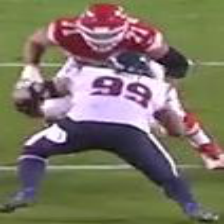

In [91]:
tensor_to_image(p_g_contact_dataset_test[30])

### Data loader

In [92]:
BATCH_SIZE = 32

loader_ground = DataLoader(p_g_contact_dataset_test,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0,
                         drop_last=False)

## Load model

In [34]:
def load_model(model_path, num_classes, device):
    """
    Returns a efficientnet model with the weights from the saved model
    """
    model = models.efficientnet_b0(pretrained=True)
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device).eval();
    
    return model

In [37]:
MODEL_DIR = "trained_models"
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ground_model_path = os.path.join(MODEL_DIR, 'bm_efficientnet_CLS_ground_v2_epoch_28.pth')
ground_contact_model = load_model(ground_model_path, 1, DEVICE)

In [38]:
torch.save(ground_contact_model, 'bm_efficientnet_CLS_ground_v2_epoch_28_full.pt')

In [94]:
#load the model
MODEL_DIR = "trained_models"
# detect the device (GPU or CPU)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

ground_model_path = os.path.join(MODEL_DIR, 'bm_efficientnet_CLS_ground_v4_epoch_10.pth')
ground_contact_model = load_model(ground_model_path, 1, DEVICE)

## Inference Function

In [98]:
def full_predict(model, data_loader, device):
    """
    Uses the model on all the data from the data loader and 
    returns the predictions
    """
    # initialize tqdm progress bar
    prog_bar = tqdm(data_loader, total=len(data_loader))
    total_predictions = torch.tensor([]).to(device)
    
    for i, inputs in enumerate(prog_bar):
        # send data to device
        inputs = inputs.to(device)
        # make a prediction with the model in evaluation mode
        with torch.no_grad():
            # activate evaluation mode for batchnorm layers
            model.eval()
            prediction = model(inputs).to(torch.float32).squeeze(dim=1)

        # add batch predictions to total list
        total_predictions = torch.cat((total_predictions, prediction), dim=0)    

    # return total predictions and total true_labels
    return total_predictions

In [102]:
# Get the ground predictions
y_pred_ground = full_predict(ground_contact_model, loader_ground, DEVICE)

  0%|          | 0/123 [00:00<?, ?it/s]

## Use the accuracy threshold to get the final clean predictions

In [105]:
ACC_THRESHOLD_GROUND = 0.45 # found during training
y_pred_ground_clean = (torch.sigmoid(y_pred_ground) > ACC_THRESHOLD_GROUND).double()
y_pred_ground_clean

tensor([0., 0., 0.,  ..., 0., 0., 1.], dtype=torch.float64)

In [150]:
#save the contact predictions as a dataframe
ground_pred_df = pd.DataFrame({'contact_id': ground_input_df['contact_id'],
                              'contact': y_pred_ground_clean})
ground_pred_df

contact_id  contact
12      58168_003392_0_38590_G      0.0
13      58168_003392_0_43854_G      0.0
14      58168_003392_0_41257_G      0.0
15      58168_003392_0_41944_G      0.0
16      58168_003392_0_42386_G      0.0
...                        ...      ...
6626  58172_003247_125_40656_G      0.0
6627  58172_003247_125_52521_G      0.0
6628  58172_003247_125_52939_G      0.0
6629  58172_003247_125_39008_G      0.0
6630  58172_003247_125_47912_G      1.0

[3918 rows x 2 columns]

## Submission

In [190]:
# initialize submission dataframe with contact = 0
submission = pd.DataFrame({'contact_id': input_df['contact_id']})
submission['contact'] = 0

# naive p2p contact prediction based on distance
P2P_DIST_THRES = 1.1 

submission['contact'] = (test_contact_df['p2p_distance'] < P2P_DIST_THRES).astype(int)

# add ground predictions found with the model
submission.set_index('contact_id', inplace=True)
submission.update(ground_pred_df.set_index('contact_id'))
submission = submission.reset_index()  # to recover the initial structure
# convert contact column type to int64
submission['contact'] = submission['contact'].astype('int64')
# save the submission as csv
submission.to_csv("submission.csv", index=False)

submission

contact_id  contact
0      58168_003392_0_38590_43854        0
1      58168_003392_0_38590_41257        0
2      58168_003392_0_38590_41944        0
3      58168_003392_0_38590_42386        0
4      58168_003392_0_38590_47944        0
...                           ...      ...
49583    58172_003247_125_40656_G        0
49584    58172_003247_125_52521_G        0
49585    58172_003247_125_52939_G        0
49586    58172_003247_125_39008_G        0
49587    58172_003247_125_47912_G        1

[49588 rows x 2 columns]

In [4]:
import multiprocess

def double(a):
    return a * 2

def driver_func():
    PROCESSES = 4
    with multiprocess.Pool(PROCESSES) as pool:
        params = [(1, ), (2, ), (3, ), (4, )]
        results = [pool.apply_async(double, p) for p in params]

        for r in results:
            print('\t', r.get())
driver_func()

	 2
	 4
	 6
	 8


In [3]:
!pip install multiprocess

In [69]:
def detect_all_data_both(contact_df, yolo_model, metadata_df, helmet_det_df, tracking_df,
                         split="Train", max_rewind=120):
    """
    Detects the players and helmets on all the data and informs where players are not detected
    """
    contact_image_end_df = pd.DataFrame({'contact_id': contact_df['contact_id']})
    contact_image_end_df['crop_generated'] = False
    contact_image_side_df = pd.DataFrame({'contact_id': contact_df['contact_id']})
    contact_image_side_df['crop_generated'] = False
    # iterate over each unique game_play code
    game_play_list = contact_df['game_play'].unique()
    for game_play in game_play_list:
        # each image from the same game_play code will pertain to the same video
        # load the video pertaining to the game_play
        video_name_end = f"{game_play}_Endzone.mp4"
        videopath_end = os.path.join(DATASET_DIR, split, video_name_end)
        cap_end = cv2.VideoCapture(videopath_end)
        
        video_name_side = f"{game_play}_Sideline.mp4"
        videopath_side = os.path.join(DATASET_DIR, split, video_name_side)
        cap_side = cv2.VideoCapture(videopath_side)
        
        # set an auxiliary dataframe with the info from the game_play
        # so that we dont have to find the rows with the given game_play each time
        contact_game_play_df = contact_df[contact_df['game_play'] == game_play]
        helmet_det_game_play_df = helmet_det_df[helmet_det_df['game_play'] == game_play]
        tracking_game_play_df = tracking_df[tracking_df['game_play'] == game_play]
        # iterate over each step from the same game_play
        step_list = contact_game_play_df['step'].unique()
        for step in step_list:
            # set the video capture to the frame pertaining to the step
            frame_number_end = step_to_frame(game_play, step, metadata_df, 'Endzone')
            res = False
            # endzone
            while res==False:
                # start at frame_number-1 (starting at 0) and go back 1 frame if it's beyond the length of the video
                frame_number_end = frame_number_end-1
                cap_end.set(cv2.CAP_PROP_POS_FRAMES, frame_number_end)
                res, frame_image_array_end = cap_end.read()
            # sideline
            frame_number_side = step_to_frame(game_play, step, metadata_df, 'Sideline')
            res = False
            while res==False:
                # start at frame_number-1 (starting at 0) and go back 1 frame if it's beyond the length of the video
                frame_number_side = frame_number_side-1
                cap_side.set(cv2.CAP_PROP_POS_FRAMES, frame_number_side)
                res, frame_image_array_side = cap_side.read()
            
            
            # correct the 1 frame offset
            frame_number_end = frame_number_end+1
            frame_number_side = frame_number_side+1
            # get all the helmet detection boxes and labels
            boxes_helmet_end, labels_helmet_end = get_helmet_detections(helmet_det_game_play_df, game_play, 
                                                                frame_number_end, 'Endzone')
            boxes_helmet_side, labels_helmet_side = get_helmet_detections(helmet_det_game_play_df, game_play, 
                                                                frame_number_side, 'Sideline')
            
            # get all the yolo detection boxes and labels
            boxes_yolo_end, labels_yolo_end = get_yolo_detections(yolo_model, array_to_image(frame_image_array_end), 0.3)
            boxes_yolo_side, labels_yolo_side = get_yolo_detections(yolo_model, array_to_image(frame_image_array_side), 0.3)
            
            # iterate over player_id_1
            player_id_1_list = contact_game_play_df[contact_game_play_df['step'] == step]['nfl_player_id_1'].unique()
            for player_id_1 in player_id_1_list:            
                # iterate over player_id_2
                player_id_2_list = contact_game_play_df[(contact_game_play_df['step'] == step) &
                                              (contact_game_play_df['nfl_player_id_1'] == player_id_1)]['nfl_player_id_2'].unique()
                for player_id_2 in player_id_2_list:
                    # recreate contact_id
                    contact_id_rec = recreate_contact_id(game_play, step, 
                                                         player_id_1, player_id_2)
                    # filter detections of the 2 players
                    boxes_helmet_filt_end, labels_helmet_filt_end = filter_helmet_detection(game_play, boxes_helmet_end, 
                                                                                      labels_helmet_end, 
                                                                                      [player_id_1, player_id_2], 
                                                                                      tracking_game_play_df)
                    boxes_helmet_filt_side, labels_helmet_filt_side = filter_helmet_detection(game_play, boxes_helmet_side, 
                                                                                      labels_helmet_side, 
                                                                                      [player_id_1, player_id_2], 
                                                                                      tracking_game_play_df)
                    # If no helmets where detected, rewind 10 frames at a time for a maximum of max_rewind frames
                    # and look for helmet detections again
                    rewinded_frames = 0
                    while(len(labels_helmet_filt_end) == 0 and rewinded_frames < max_rewind):
                        rewinded_frames += 10
                        # detect the helmets on the rewinded frame
                        boxes_helmet_rewind_end, labels_helmet_rewind_end = get_helmet_detections(helmet_det_game_play_df, 
                                                                                          game_play, 
                                                                    frame_number_end-rewinded_frames, 'Endzone')
                        # filter detections of the 2 players
                        boxes_helmet_filt_end, labels_helmet_filt_end = filter_helmet_detection(game_play, 
                                                                                        boxes_helmet_rewind_end, 
                                                                                        labels_helmet_rewind_end, 
                                                                                        [player_id_1, player_id_2], 
                                                                                        tracking_game_play_df)
                        
                    # save the number of rewinded frames to the result dataframe
                    contact_image_end_df.loc[(contact_image_end_df['contact_id'] == contact_id_rec), 
                                         ['rewinded_frames']] = rewinded_frames
                    
                    # sideline
                    rewinded_frames = 0
                    while(len(labels_helmet_filt_side) == 0 and rewinded_frames < max_rewind):
                        rewinded_frames += 10
                        # detect the helmets on the rewinded frame
                        boxes_helmet_rewind_side, labels_helmet_rewind_side = get_helmet_detections(helmet_det_game_play_df, 
                                                                                          game_play, 
                                                                    frame_number_side-rewinded_frames, 'Sideline')
                        # filter detections of the 2 players
                        boxes_helmet_filt_side, labels_helmet_filt_side = filter_helmet_detection(game_play, 
                                                                                        boxes_helmet_rewind_side, 
                                                                                        labels_helmet_rewind_side, 
                                                                                        [player_id_1, player_id_2], 
                                                                                        tracking_game_play_df)
                        
                    # save the number of rewinded frames to the result dataframe
                    contact_image_side_df.loc[(contact_image_side_df['contact_id'] == contact_id_rec), 
                                         ['rewinded_frames']] = rewinded_frames
                        
                    # save the number of missed helmet detections
                    missed_helmet_dets_end = 2 - len(labels_helmet_filt_end) if player_id_2 != -1 else 1 - len(labels_helmet_filt_end)
                    contact_image_end_df.loc[(contact_image_end_df['contact_id'] == contact_id_rec), 
                                         ['miss_helmet_dets']] = missed_helmet_dets_end
                    
                    missed_helmet_dets_side = 2 - len(labels_helmet_filt_side) if player_id_2 != -1 else 1 - len(labels_helmet_filt_side)
                    contact_image_side_df.loc[(contact_image_side_df['contact_id'] == contact_id_rec), 
                                         ['miss_helmet_dets']] = missed_helmet_dets_side
                    # get the contact box
                    contact_box_end, num_det_end = get_contact_box(boxes_helmet_filt_end, labels_helmet_filt_end,
                                                        boxes_yolo_end, labels_yolo_end, 
                                                        array_to_image(frame_image_array_end).size, 'Endzone')
                    contact_box_side, num_det_side = get_contact_box(boxes_helmet_filt_side, labels_helmet_filt_side,
                                                        boxes_yolo_side, labels_yolo_side, 
                                                        array_to_image(frame_image_array_side).size, 'Sideline')
                    
                    # save the number of missed player detections
                    missed_player_dets_end = 2 - num_det_end if player_id_2 != -1 else 1 - num_det_end
                    contact_image_end_df.loc[(contact_image_end_df['contact_id'] == contact_id_rec), 
                                         ['miss_player_dets']] = missed_player_dets_end
                    
                    missed_player_dets_side = 2 - num_det_side if player_id_2 != -1 else 1 - num_det_side
                    contact_image_side_df.loc[(contact_image_side_df['contact_id'] == contact_id_rec), 
                                         ['miss_player_dets']] = missed_player_dets_side
                    
                    if len(contact_box_end) != 0:
                        # crop the image
                        cropped_image_array_end = frame_image_array_end[contact_box_end[1]:contact_box_end[3], # y coordinates
                                                                contact_box_end[0]:contact_box_end[2]] # x coordinates
                        cropped_image_end = array_to_image(cropped_image_array_end)
                        
                        # save the cropped image
                        crop_name_end = f"{contact_id_rec}_Endzone.jpg"
                        cropped_image_end.save(os.path.join(DATASET_DIR, split, 'crops', crop_name_end))
                        contact_image_end_df.loc[(contact_image_end_df['contact_id'] == contact_id_rec), 
                                         ['crop_generated']] = True
                        
                        
                    if len(contact_box_side) != 0:  
                        # crop the image
                        cropped_image_array_side = frame_image_array_side[contact_box_side[1]:contact_box_side[3], # y coordinates
                                                                contact_box_side[0]:contact_box_side[2]] # x coordinates
                        cropped_image_side = array_to_image(cropped_image_array_side)
                        
                        # save the cropped image
                        crop_name_side = f"{contact_id_rec}_Sideline.jpg"
                        cropped_image_side.save(os.path.join(DATASET_DIR, split, 'crops', crop_name_side))
                        contact_image_side_df.loc[(contact_image_side_df['contact_id'] == contact_id_rec), 
                                         ['crop_generated']] = True

                
    return contact_image_end_df, contact_image_side_df    

In [70]:
# test split
# endzone
start_time = time.time()
contact_image_endzone_df, contact_image_sideline_df = detect_all_data_both(test_contact_df_reduced, yolo_model, test_video_metadata_df, 
                                                      test_helmet_detection_df, test_player_tracking_df, "test",
                                                      max_rewind=120)
end_time = time.time()
print(f"Contact image cropping finished after {(end_time - start_time):.2f} seconds")

contact_image_sideline_df

Contact image cropping finished after 446.23 seconds


contact_id  crop_generated  rewinded_frames  \
10     58168_003392_0_38590_44822            True              0.0   
11     58168_003392_0_38590_39947            True              0.0   
13     58168_003392_0_38590_42565            True              0.0   
50     58168_003392_0_41944_42565            True              0.0   
119    58168_003392_0_37211_46445            True              0.0   
...                           ...             ...              ...   
49583    58172_003247_125_40656_G            True              0.0   
49584    58172_003247_125_52521_G            True             90.0   
49585    58172_003247_125_52939_G            True              0.0   
49586    58172_003247_125_39008_G            True             40.0   
49587    58172_003247_125_47912_G            True             30.0   

       miss_helmet_dets  miss_player_dets  
10                  0.0               2.0  
11                  0.0               2.0  
13                  0.0               2.0  
50                  0.0               1.0  
119                 0.0               2.0  
...                 ...               ...  
49583               0.0               1.0  
49584               0.0               1.0  
49585               0.0               0.0  
49586               0.0               1.0  
49587               0.0               1.0  

[6631 rows x 5 columns]